In [16]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import matplotlib.pyplot as plt

In [17]:
EPS = 1e-8

In [18]:
def toy_results_plot(data, data_generator=None, hypers=None, predictions=None):   
    train_x = np.arange(np.min(data[0][0].reshape(-1)),
                        np.max(data[0][0].reshape(-1)), 1/100)
    
    # plot the training data distribution
    if data_generator is not None:
        plt.plot(train_x, data_generator['mean'](train_x), 'red', label='data mean')
        plt.fill_between(train_x,
                         data_generator['mean'](train_x) - data_generator['std'](train_x),
                         data_generator['mean'](train_x) + data_generator['std'](train_x),
                         color='orange', alpha=1, label='data 1-std')
    plt.plot(data[0][0], data[0][1], 'r.', alpha=0.2, label='train sampl')

    # plot the model distribution
    if predictions is not None:
        x = predictions[0]
        y_mean   = predictions[1]['mean'][:,0]
        ell_mean = predictions[1]['mean'][:,1]
        y_var    = predictions[1]['cov'][:,0,0]
        ell_var  = predictions[1]['cov'][:,1,1]
        
        if hypers['style'] != 'heteroskedastic':
            ell_mean = hypers["homo_logvar_scale"]
            ell_var = 0

        heteroskedastic_part = np.exp(0.5 * ell_mean)
        full_std = np.sqrt(y_var + np.exp(ell_mean + 0.5 * ell_var))

        plt.plot(x, y_mean, label='model mean')
        plt.fill_between(x,
                         y_mean - heteroskedastic_part,
                         y_mean + heteroskedastic_part,
                         color='g', alpha = 0.2, label='$\ell$ contrib')
        plt.fill_between(x,
                         y_mean - full_std,
                         y_mean + full_std,
                         color='b', alpha = 0.2, label='model 1-std')
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3,2])
    plt.legend()
    plt.show()


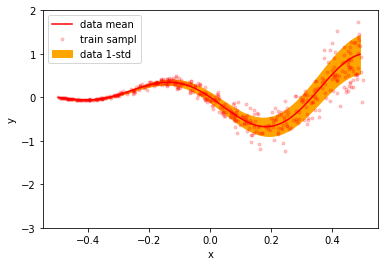

In [19]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []

for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data(x).reshape(-1)]) 
    
x = np.arange(-1, 1,  1/100)
toy_data.append([[[_] for _ in x], base_model(x)])

toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model})

In [20]:
x_train = torch.FloatTensor(toy_data[0][0])
y_train = torch.FloatTensor(toy_data[0][1])

In [21]:
def matrix_diag_part(tensor):
    return torch.stack(tuple(t.diag() for t in torch.unbind(tensor,0)))

In [22]:
def KL_GG(p_mean, p_var, q_mean, q_var):
    """
        Compute KL between two diagonal gaussians
    """
    s_q_var = q_var + EPS
    entropy = 0.5 * (1 + math.log(2 * math.pi) + torch.log(p_var))
    cross_entropy = 0.5 * (math.log(2 * math.pi) + torch.log(s_q_var) + \
                          (p_var + (p_mean - q_mean)**2) / s_q_var)
    return torch.sum(cross_entropy -  entropy)

In [23]:
class LinearGaussian(nn.Module):
    def __init__(self, in_dim, out_dim, certain=False, prior='DiagonalGaussian'):
        
        super().__init__()
        
        self.A_mean = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.b_mean = nn.Parameter(torch.Tensor(out_dim))
        self.certain = certain
        
        self.A_var = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.b_var = nn.Parameter(torch.Tensor(out_dim))
        
        self.prior = prior
        self.initialize_weights()
        self.construct_priors(self.prior)
        
    
    def initialize_weights(self):
        nn.init.zeros_(self.A_mean)
        nn.init.zeros_(self.b_mean)
        
        shape = self.b_var.size(0)
        s = shape * shape
        
        nn.init.uniform_(self.A_var, a=0, b=s)
        nn.init.uniform_(self.b_var, a=0, b=s)
        
    def construct_priors(self, prior):
        if prior == "DiagonalGaussian":
            s1 = 1
            s2 = 1
                        
            self._prior_A = {'mean' : torch.zeros_like(self.A_mean, requires_grad=False),
                             'var'  : torch.ones_like(self.A_var, requires_grad=False) * s2}
            self._prior_b = {'mean' : torch.zeros_like(self.b_mean, requires_grad=False),
                             'var'  : torch.ones_like(self.b_var, requires_grad=False) * s1}
        else:
            raise NotImplementedError("{} prior is not supported".format(prior))
    
    def compute_kl(self):
        if self.prior == 'DiagonalGaussian':
            kl_A =  KL_GG(self.A_mean, self.A_var, self._prior_A['mean'], self._prior_A['var'])
            kl_b =  KL_GG(self.b_mean, self.b_var, self._prior_b['mean'], self._prior_b['var'])
        return kl_A + kl_b
            
    def forward(self, x):
        
        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]
        
        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean
        
        if self.certain:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, self.A_var.t()) + self.b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)
        
        return (y_mean, y_var)      

    def compute_var(self, x_mean, x_var):
        x_var_diag = matrix_diag_part(x_var)
        xx_mean = x_var_diag + x_mean * x_mean
        
        term1_diag = torch.matmul(xx_mean, self.A_var)
        
        flat_xCov = torch.reshape(x_var, (-1, self.A_mean.size(0)))  # [b*x, x]
        xCov_A = torch.matmul(flat_xCov, self.A_mean)  # [b * x, y]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0), self.A_mean.size(1))) # [b, x, y]
        xCov_A = torch.transpose(xCov_A, 1, 2)  # [b, y, x]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0)))  # [b*y, x]
        
        A_xCov_A = torch.matmul(xCov_A, self.A_mean)  # [b*y, y]
        A_xCov_A = torch.reshape(A_xCov_A, (-1, self.A_mean.size(1), self.A_mean.size(1)))  # [b, y, y]
        
        term2 = A_xCov_A
        term2_diag = matrix_diag_part(term2)
        
        term3_diag = self.b_var
        result_diag = term1_diag + term2_diag + term3_diag
        return torch.diag_embed(result_diag)

In [24]:
class RegressionLoss(nn.Module):
    def __init__(self, net, method='bayes', use_heteroskedastic=True, homo_log_var_scale=None):
        super().__init__()
        
        self.net = net
        self.method = method
        self.use_het = use_heteroskedastic
        if not self.use_het and homo_log_var_scale is None:
            raise ValueError("homo_log_var_scale must be set in homoskedastic mode")
        
        self.homo_log_var_scale = torch.FloatTensor([homo_log_var_scale])
            
    def gaussian_likelihood_core(self, target, mean, log_var, smm, sml, sll):
        const = math.log(2 * math.pi)
        exp = torch.exp(-log_var + 0.5 * sll)
        return const + log_var + exp * (smm + (mean - sml - target) ** 2)
    
    def heteroskedastic_gaussian_loglikelihood(self, pred_mean, pred_var, target):
        log_var = pred_mean[:, 1].view(-1)
        mean = pred_mean[:, 0].view(-1)
        
        if self.method.lower() == 'bayes':
            sll = pred_var[:, 1, 1].view(-1)
            smm = pred_var[:, 0, 0].view(-1)
            sml = pred_var[:, 0, 1].view(-1)
        else:
            sll = smm = sml = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml, sll)

    def homoskedastic_gaussian_loglikelihood(self, pred_mean, pred_var, target):
        log_var = self.homo_log_var_scale
        mean = pred_mean[:, 0].view(-1)
        sll = sml  = 0
        if self.method.lower() == 'bayes':
            smm = pred_var[:, 0, 0].view(-1)
        else:
            smm = 0
        return self.gaussian_likelihood_core(target, mean, log_var, smm, sml, sll)
    
    def forward(self, pred, target):
        pred_mean = pred[0]
        pred_var = pred[1]
        
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'compute_kl'):
                kl = kl + module.compute_kl()
        
        gaussian_likelihood = self.heteroskedastic_gaussian_loglikelihood if self.use_het \
                              else self.homoskedastic_gaussian_loglikelihood
        
        log_likelihood = gaussian_likelihood(pred_mean, pred_var, target)
        batched_likelihood = torch.mean(log_likelihood)
        
        loss = kl - batched_likelihood
        return loss, batched_likelihood.detach(), kl

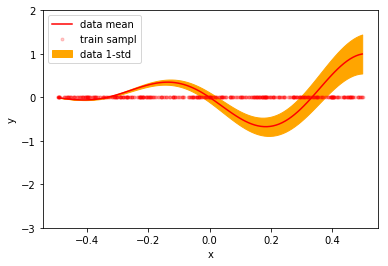

epoch: 1001, train loss : 0.225360
epoch: 1101, train loss : 0.225359
epoch: 1201, train loss : 0.225359
epoch: 1301, train loss : 0.225359
epoch: 1401, train loss : 0.225359


KeyboardInterrupt: 

In [263]:
epochs = 20000
for epoch in range(epochs):
    model.train()
    y_ans = model(x_train)
    loss = mse(y_ans, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if epoch % 100 == 0:
        if epoch % 1000 == 0:
            clear_output()            
            model.eval()
            
            x = toy_data[1][0]
            y_true = toy_data[1][1]
            y_pred = model(torch.FloatTensor(x))
            
            plt.figure()
            toy_results_plot([[x, y_pred.detach().numpy()]], {'mean':base_model, 'std':noise_model})
            
        print("epoch: {}, train loss : {:.6f}".format(epoch + 1, loss.item()))

In [ ]:
x = toy_data[1][0]
y_true = toy_data[1][1]

y_pred = model(torch.FloatTensor(x))

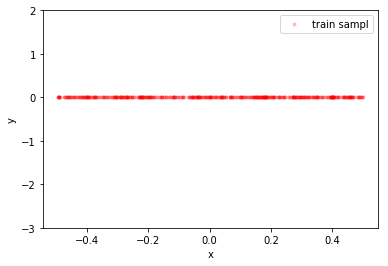

In [255]:
toy_results_plot([[x, y_pred.detach().numpy()]])

In [264]:
from sklearn.linear_model import LinearRegression

In [265]:
reg = LinearRegression()
reg.fit(x, y_true)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [379]:
yy[0].shape, yy[1].shape

(torch.Size([500, 1]), torch.Size([500, 1, 1]))

## Смотрим что такие же ответы